<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第４章</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		前回に続き、<a href="http://www.amazon.co.jp/dp/400006973X/">データ解析のための統計モデリング入門</a>
		（以下、久保本と書きます）
		の第４章の例題をSageを使って再現してみます。
	</p>
	<p>
		4章のメインは、久保本図4.9（以下に引用）のバイアス補正とその分布にあると思います。		
	</p>
	<p>
		<img src="images/fig-4.9.png"/>
	</p>
	<p>
		数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるの大きな特徴です。
		この機会にSageを分析に活用してみてはいかがでしょう。
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。jupyter用に新しくなったRUtil.pyも使います。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>あてはまりの良さとモデルの複雑さ</h2>
	<p>
		「あてはまりの良さとモデルの複雑さ」を説明するために、３章のデータを使ってk=1とk=7の結果の比較が示されています。
		このような図を簡単に再現できれば、実際の分析の時にも役立つと思います。
	</p>
	<p>
		3章のデータをも一度読み込み、statsmodelsのglmを使ってk=1とその結果をプロットします。
	</p>
</html>

In [3]:
# 3章のデータをもう一度読み込む
d = pd.read_csv('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')
d_C = d[d['f'] == 'C']
d_T = d[d['f'] == 'T']

In [4]:
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

In [5]:
# k=1でのglm回帰を実行
fit_1 = smf.glm('y ~ 1', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
# λの予測値をλ_1にセット
d['lam_1'] = fit_1.predict()

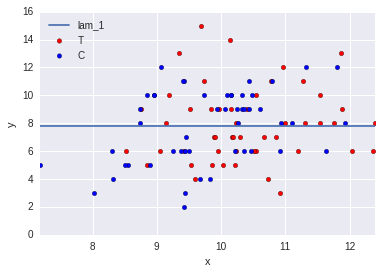

In [6]:
# λの予測値と一緒にプロット
ax = d.sort_values(by=['x']).plot(x='x', y='lam_1')
d_T.plot(kind='scatter', x='x', y='y', c='r', ax=ax, label='T')
d_C.plot(kind='scatter', x='x', y='y', c='b', ax=ax, label='C')
plt.legend(loc='upper left')
plt.show()

<html>
	<h3>多次元のglmをstatsmodelsで行う</h3>
	<p>
		次にk=7（$log \lambda = \beta_1 + \beta_2 x + ... + \beta_7 x^6$）の計算は、$x^n$
      を計算するカスタム関数nPwOfをformulaの中で使用することで、実現できました。
	</p>
    <p>
      予測値は、データのある点のみを結線したため、カクカクしているところもありますが、データの中心部分を通っています。
    </p>
    <p>
      k=1とk=7の結果をみるとk=7の結果は、あまりにも複雑な曲線を示しており、機械学習でいうところの「過学習」 
      （Overfitting）の状態になっています。過学習では、学習用データ（ここでいうサンプルデータ）に引きずられ、 
      真のモデルから離れてしまいます。
    </p>
</html>

In [7]:
# カスタム関数nPwOfを使って多項式近似を行う
def nPwOf(n, x):
    return x^n
formula = 'y ~ nPwOf(7, x) +  nPwOf(6, x) + nPwOf(5, x) + nPwOf(4, x) +  nPwOf(3, x) + nPwOf(2, x) + x'
fit_1 = smf.glm(formula=formula, data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
# λの予測値をλ_1にセット
d['lam_7'] = fit_1.predict()

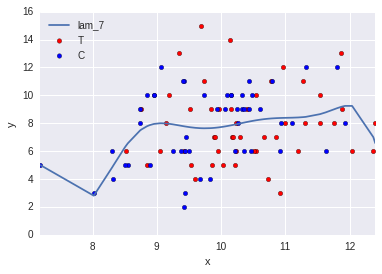

In [8]:
# λの予測値と一緒にプロット
ax = d.sort_values(by=['x']).plot(x='x', y='lam_7')
d_T.plot(kind='scatter', x='x', y='y', c='r', ax=ax, label='T')
d_C.plot(kind='scatter', x='x', y='y', c='b', ax=ax, label='C')
plt.legend(loc='upper left')
plt.show()

<html>
	<h2>さまざまな逸脱度</h2>
	<p>
		逸脱度は、「あてはまりの悪さ」を表現する指標と久保本では説明されています。
	</p>
	<p>
		最大対数尤度を$log L^*$とすると、逸脱度(D)は以下の様に定義されます。
$$
	D = -2 log L^*
$$		
	</p>
	<p>
		4章で登場する逸脱度を以下の表に示します。
		最大の逸脱度は、一定モデルで、最小の逸脱度はフルモデルです。
	</p>
</html>

In [9]:
# 様々な逸脱度
hdr = ['名前', '定義']
tbl = [ ['逸脱度(D)', '-2 log L*'], 
            ['最小の逸脱度', 'フルモデルをあてはめたときのD'],
            ['残差逸脱度', 'D-最小のD'],
            ['最大の逸脱度', 'NullモデルをあてはめたときのD'],
            ['Null逸脱度', '最大のD - 最小のD']]
Table2Html(tbl, hdr)

名前,定義
逸脱度(D),-2 log L*
最小の逸脱度,フルモデルをあてはめたときのD
残差逸脱度,D-最小のD
最大の逸脱度,NullモデルをあてはめたときのD
Null逸脱度,最大のD - 最小のD


<html>
	<p>
		各モデルのglmのfit結果を求めて、その結果を表にまとめます。
	</p>	
	<p>
		ここで出てくるモデル選択の基準となるAIC(Akaike's information criterion)は、以下の様に定義されています。
$$
	AIC = -2 { (最大対数尤度) - (最尤推定したパラメータの数)} = D + 2k
$$		

	</p>
</html>

In [10]:
# 逸脱度（Deviance）は、-2 log L* と定義されており、glmの結果の-2*llfから計算できる
# 各モデルに対するfitを計算してDevianceの違いを整理してみる
fit_f = smf.glm('y ~ f', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit_x = smf.glm('y ~ x', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit_x_f = smf.glm('y ~ x + f', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()

<html>
	<p>
		データの個数と同じ数のパラメータを使ってあてはめたモデルがフルモデルです。
		これは、実際にそのようなモデルを作って計算するのでは無く、フルモデルはすべての観測値が予測値と一致するモデルであり、
		その結果、残差は０であり、対数尤度は、以下のようになります。
	</p>	
</html>

In [11]:
# フルモデルの対数尤度の計算
fullLogL = sageobj(sum([r.dpois(y, y, log=True) for y in d.y])); fullLogL

-192.889752524496

<html>
	<p>
		結果をみやすくするために、小数点以下3桁を表示する関数prf3を定義します。
	</p>
</html>

In [12]:
# 結果を小数点3桁で表示する
def prf3(f):
    return '%.3f'%f

In [13]:
# フルモデルは、k=Nで結果がすべて観測値と一致します。従って残差は0となります。 
# log L*: fit.llf, residual deviance: fit.deviance, AIC: fit.aicで取得できる
hdr = ['モデル', 'k', "log L*", 'deviance -2 log L*', 'residual deviance', 'AIC']
tbl = [['一定', '1', prf3(fit_1.llf),  prf3(-2*fit_1.llf),  prf3(fit_1.deviance), prf3(fit_1.aic)],
            ['f', '2', prf3(fit_f.llf),  prf3(-2*fit_f.llf),  prf3(fit_f.deviance), prf3(fit_f.aic)],
            ['x', '2', prf3(fit_x.llf),  prf3(-2*fit_x.llf),  prf3(fit_x.deviance), prf3(fit_x.aic)],
            ['x+f', '3', prf3(fit_x_f.llf),  prf3(-2*fit_x_f.llf),  prf3(fit_x_f.deviance), prf3(fit_x_f.aic)],
            ['フル', '100', prf3(fullLogL), prf3(-2*fullLogL), '0', prf3(-2*fullLogL+2*100)]]
Table2Html(tbl, hdr)

モデル,k,log L*,deviance -2 log L*,residual deviance,AIC
一定,1,-231.863,463.727,77.947,479.727
f,2,-237.627,475.255,89.475,479.255
x,2,-235.386,470.773,84.993,474.773
x+f,3,-235.294,470.587,84.808,476.587
フル,100,-192.890,385.780,0,585.780


<html>
	<h2>平均対数尤度を使ったモデルの予測の良さ</h2>
	<p>
		いよいよ図４．９の計算に入ります。久保本ではモデル選択の指標としてAICが使えるのかを一定モデルを使って
		数値例で示しています。（これが久保本のすごいところ！）
	</p>
	<p>
		平均の対数尤度は、真のモデルを使って生成されたサンプルから求めた対数尤度の平均値であり、実際のモデルづくりでは
		このようなことは不可能ですが、平均対数尤度と推定されたモデルの関係とこの差（バイアス）bの分布からAICの意味するところを
		表現しています。bの定義は以下の通りです。
$$
	b = log L^* - E(Log L)
$$		
	</p>	
</html>
<html>
	<h3>観測データが一つの場合</h3>
	<p>
		図４．９の(A)観測データが一つの場合について、真のモデルλ=8のポアソン分布から50個のサンプルを生成します。
	</p>
	<p>
		準備としてサンプル生成関数genSample, 対数尤度を計算するlogLを定義します。
	</p>
</html>

In [14]:
# サンプル生成λ=8ポアソン分布のサンプルをN=50個生成する
# sample = [ float(y.n()) for y in r.rpois(N, lambda_true)]
# sageobjを使って変換する方が速いのでgenSample関数を使用する
def genSample(lambda_target, sample_size):
    return sageobj(r('rpois(%d, %f)'%(sample_size, lambda_target)))

In [15]:
# Rの乱数の種をセット
r('set.seed(101)')
# 真のλ=8から50個のポアソン分布のサンプルを生成する
N = 50
lambda_true = 8
sample = genSample(lambda_true, N)
sampleDf = pd.DataFrame({'y' : np.array(sample)})

In [16]:
# 対数尤度の計算
def logL(sample, lambda_estimated):
    return sageobj(sum([r.dpois(y, lambda_estimated, log=True) for y in sample]))

<html>
	<p>
		glmを使って一定モデルの結果を取得します。ここでは対数尤度が-116.7、 $\beta_1$の値は2.06と求まりました。
	</p>
</html>

In [17]:
# k=1でのglm回帰を実行
fit = smf.glm('y ~ 1', data=sampleDf, family=sm.families.Poisson(link=sm.families.links.log)).fit()

In [18]:
# fit.summary2()
# 最大対数尤度
mxLogL = fit.llf
# 切片
beta_1 = fit.params[0]
print mxLogL, beta_1

-116.764129142 2.06686275947


<html>
	<p>
		この結果を図化し、logL_pltにセットします。
	</p>
</html>

In [19]:
# β= [1.95, 2.20]の範囲の対数尤度を求める
logL_lst = [ (x,logL(sample, exp(x)) )for x in  np.arange(1.95, 2.20, 0.01)]
# log L*の曲線プロット
logL_plt = list_plot(logL_lst, figsize=4, plotjoined =True)

<html>
	<p>
		つぎに、真のモデルから50個のサンプルを200セット生成し、平均の対数尤度を計算します。
	</p>
</html>

In [20]:
# 真のλ=8から生成されたサンプル200セットにβの推定値を使って対数尤度を計算
# logL200 = [ logL(genSample(lambda_true, N), exp(beta_1)) for i in range(50)]
# とても遅いので、
logL200 = [ sageobj(r('sum(log(dpois(rpois(%d, %f), %f)))'%(N, lambda_true, exp(beta_1)))) for i in range(200)]

<html>
	<p>
		求まった結果を一つにプロットします。logL*を赤○で、平均対数尤度を緑○で、各対数尤度を小さな青○で示し、
		各βの対数尤度曲線と一緒に表示したのが、以下の図です。
	</p>
</html>

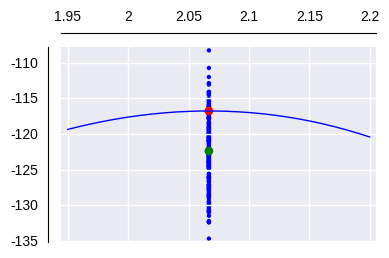

In [21]:
sample_plt = list_plot([ (beta_1, y) for y in logL200])
logL_pt = point((beta_1, mxLogL), size=40, color="red")
logL_mean_pt = point((beta_1, mean(logL200)), size=40, color="green")
(logL_plt + sample_plt + logL_pt + logL_mean_pt).show()

In [22]:
# 実際の解析では不可能ですが、今回は真のモデルが分かっているので、評価用のデータを生成し、E(logL)を計算できます

<html>
	<h3>繰り返しは簡単</h3>
	<p>
		次に上記の処理を繰り返した図４．９(B)を試してみます。
		Sageでは、一度試した処理をコピー＆ペーストしてループに入れたり、関数にすることで結果を確認しながら
		処理を進めることで効率良く目的のグラフを得ることができます。
	</p>
	<p>
		最初に空のGraphics=gを生成し、上記の処理と同じことをして、プロット結果をgに加えていきます。
		たったこれだけで、図４．９の(B)が再現できます。
	</p>
	<p>
		Rのseedをセットすることで、久保本の平均対数尤度に近い曲線が表示されました。（2016/07/17）
	</p>
</html>

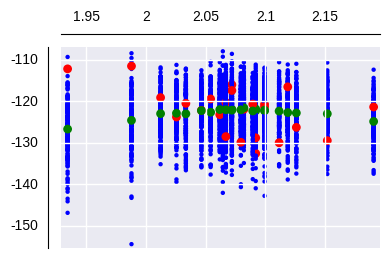

In [23]:
#  上記の計算を25回繰り返しプロット図4.9(B)
g = Graphics()
for i in range(25):
    sample = genSample(lambda_true, N)
    sampleDf = pd.DataFrame({'y' : np.array(sample)})
    # k=1でのglm回帰を実行
    fit = smf.glm('y ~ 1', data=sampleDf, family=sm.families.Poisson(link=sm.families.links.log)).fit()    # 最大対数尤度
    mxLogL = fit.llf
    # 切片
    beta_1 = fit.params[0]
    logL200 = [ sageobj(r('sum(log(dpois(rpois(%d, %f), %f)))'%(N, lambda_true, exp(beta_1)))) for i in range(200)]
    # プロット
    g +=  list_plot([ (beta_1, y) for y in logL200])
    g += point((beta_1, mxLogL), size=40, color="red")
    g += point((beta_1, mean(logL200)), size=40, color="green")
# 結果を表示
g.show(figsize=4)

<html>
	<h2>バイアスbの計算</h2>
	<p>
		非常に時間がかかったので試しに10セットのデータに対してバイアスbを計算し、その分布を表示してみました。
	</p>
	<p>
		バイアスbは、2.7と久保本の1.01とはずれています。
	</p>
</html>

In [24]:
# バイアスbの計算
def bias(lambda_true, N):
    sample = genSample(lambda_true, N)
    sampleDf = pd.DataFrame({'y' : np.array(sample)})
    # k=1でのglm回帰を実行
    fit = smf.glm('y ~ 1', data=sampleDf, family=sm.families.Poisson(link=sm.families.links.log)).fit()    
    # 最大対数尤度
    mxLogL = fit.llf
    # 切片
    beta_1 = fit.params[0]
    logL200 = [ sageobj(r('sum(log(dpois(rpois(%d, %f), %f)))'%(N, lambda_true, exp(beta_1)))) for i in range(200)]
    return    (mxLogL - sageobj(mean(logL200)) )

In [25]:
# 時間がかかるので、50個だけサンプルを生成しました
bias_sample =  [bias(lambda_true, N) for i in range(50)]

In [26]:
mean(bias_sample)

2.7066865786446273

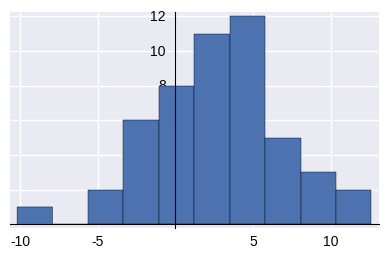

In [27]:
# biasのヒストグラムを表示する
histogram(bias_sample, figsize=4)

<html>
	<h3>Rで計算</h3>
	<p>
		久保本のサポートページにあるRの関数を使ってサンプル1000セットでバイアスbを計算してみました。
		これでも久保本の1.01とはずれており、その分布をみると-20から20の区間でかなりぶれていることがわかります。
	</p>
	<p>
		バイアスの定義を変形すると、平均対数尤度$E(logL)$は以下の様になります。
$$
	E(log L) = log L^* - b
$$		
		ここで、一定モデルのk=1であることからバイアスbとkを入れ替えるとAICの定義となり、
		AICが予測の「悪さ」を表す指標となっていることがうなずけます。
$$
	AIC = -2 \times (log L^* -1)
$$		
	</p>
</html>

Rの関数をdata/bias.txtに定義します。

In [28]:
%%writefile data/bias.txt
bias <- function(lambda.true, sample.size){
  sample.rpois <- rpois(sample.size, lambda.true)
  fit <- glm(sample.rpois~1, family=poisson) 
  lambda.estimated <- exp(coef(fit))
  likelihood.mean <- mean(sapply(1:200, function(i){sum(log(dpois(rpois(N, lambda.true), lambda.estimated)))}))
  logLik(fit) - likelihood.mean
}

Overwriting data/bias.txt


In [29]:
# Rでbiasを計算する関数を定義すると非常に速く計算できる
r('source("data/bias.txt") ')
# サンプリングが1000くらいでもbiasの平均は、結構ぶれる
r('N <- 50')
r('lambda.true <- 8')
r('bias.sampled <- sapply(1:1000, function(i) bias(lambda.true, N))')
r('mean(bias.sampled)')

[1] 0.7929698

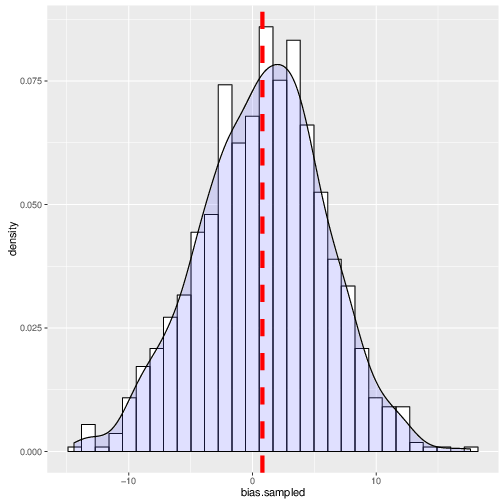

In [30]:
graph = preGraph("images/fig-4.10-R.pdf")
r('p <- qplot(bias.sampled, geom = "blank") + geom_histogram(aes(y = ..density..),  colour = "black", fill = "white") + geom_density(alpha = 0.2, fill = "#6666FF") +   geom_vline(aes(xintercept = mean(bias.sampled)), color = "red", linetype = "dashed",  size = 2) ')
r('plot(p)')
postGraph(graph)